In [4]:
import os
import numpy as np
import mne
import imageio
import h5py
# import scipy.fftpack
import matplotlib
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
# import scipy.io as sio
# from scipy.integrate import simps
import pandas as pd
# from scipy import fft
import matplotlib.mlab as mlab
import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\py_functions')

from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath

root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance


import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

import freq_funcs as ff

regions = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\elab_labels.xlsx", sheet_name='regions', header=0)
color_regions = regions.color.values
regions = regions.label.values

CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24, 3))
CR_color[6:18, :] = np.array([253, 184, 19]) / 255

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [6]:
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'
if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

In [130]:
subj = 'EL017'


path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'
path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

        
Fs = 500

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '/' + folder + '/data/Stim_list_*')

stimlist = pd.read_csv(files_list[-1])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all = lbls.label.values
labels_clinic = lbls.Clinic.values
labels_region = lbls.Region.values
labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
labels_region[labels_region == 'ENT'] = 'Basotemporal'
bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]


file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)

In [8]:
EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/EEG_resp.npy')
stimlist = pd.read_csv(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/data/stimlist.csv')


## Plot single conenction example

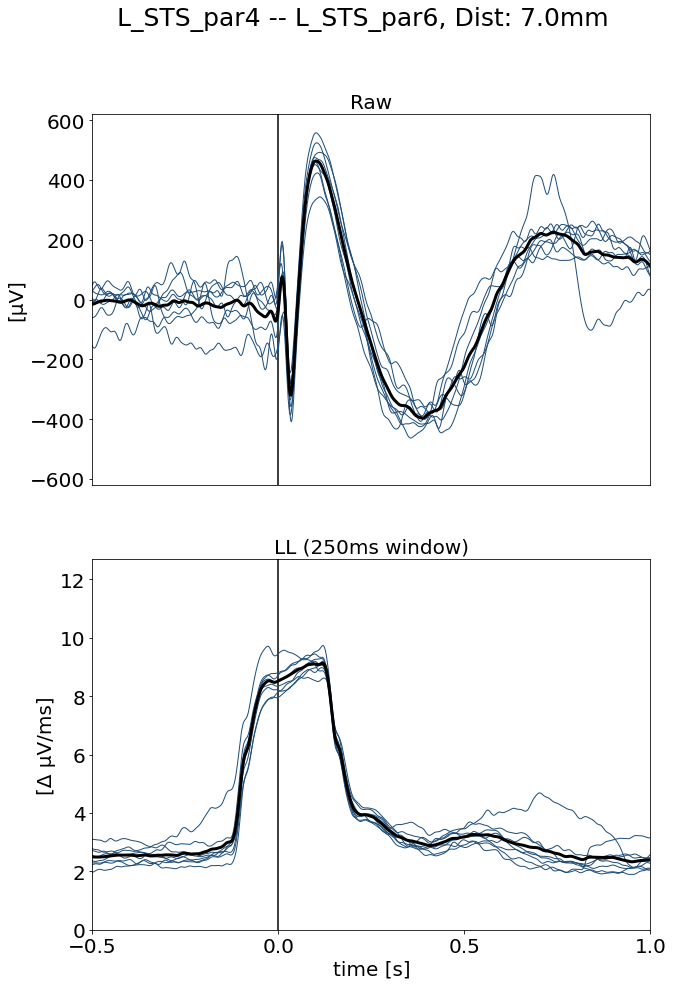

In [75]:
plot_con(3,5, con_trial,EEG_resp)

In [61]:
def plot_con(sc, rc, LL_CCEP,EEG_resp):
    t_0 = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Block']==1)]
    fig   = plt.figure(figsize=(10,15) )
    gs       = fig.add_gridspec(2,1)
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.suptitle(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm',fontsize=25)
    

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    fig.add_subplot(gs[0, 0])
    plt.title('Raw',fontsize=20)
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum_all,:])*1.1,300]),np.max([np.max(EEG_resp[rc,stimNum_all,:])*1.1,300])])
    plt.xlim([-0.5,1])
    plt.axvline(0, c=[0,0,0])
    plt.xticks([])
    plt.yticks(fontsize=20)
    plt.ylabel('[\u03BCV]', fontsize=20)
    resps = EEG_resp[:,stimNum_all,:]
    LL_all = LL_funcs.get_LL_all(resps[[rc],:,:], Fs,0.25, 1, 0)
    for i in range(len(stimNum_all)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=3)
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    fig.add_subplot(gs[1, 0])
    plt.title('LL (250ms window)',fontsize=20)
    plt.xlim([-0.5,1])
    plt.axvline(0, c=[0,0,0])
    plt.xticks([-0.5,0, 0.5, 1],fontsize=20)
    plt.xlabel('time [s]',fontsize=20)
    plt.ylim([0,np.max(LL_all[0,:,:])*1.3])
    plt.yticks(fontsize=20)
    plt.ylabel('[\u0394 \u03BCV/ms]', fontsize=20)
    for i in range(len(stimNum_all)):
        plt.plot(x_ax,ff.lp_filter(LL_all[0,i,:],45,Fs), c=color_elab[0], linewidth=1)
    
    plt.plot(x_ax,ff.lp_filter(np.mean(LL_all[0,:,:],0),45,Fs), c=[0,0,0], linewidth=3)
    plt.savefig('T:\EL_experiment\Patients\\all\\Analysis\LL\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig('T:\EL_experiment\Patients\\all\\Analysis\LL\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    
    plt.show()

In [7]:
con_trial

,Chan,Stim,LL,P2P,Hour,Block,Sleep,Num,Num_block,Date,Artefact,d
0,3.0,44.0,1.388413,75.136726,8.0,1.0,0.0,1.0,1.0,20210225.0,0.0,65.43
1,3.0,40.0,1.312352,55.407638,8.0,1.0,0.0,2.0,2.0,20210225.0,0.0,55.64
2,3.0,58.0,1.985708,112.844598,8.0,1.0,0.0,3.0,3.0,20210225.0,0.0,40.78
3,3.0,59.0,1.696419,95.103471,8.0,1.0,0.0,4.0,4.0,20210225.0,0.0,38.64
4,3.0,17.0,1.575557,89.525837,8.0,1.0,0.0,5.0,5.0,20210225.0,0.0,45.95
...,...,...,...,...,...,...,...,...,...,...,...,...
20950,82.0,43.0,0.872779,54.432276,9.0,3.0,0.0,567.0,162.0,20210225.0,0.0,45.67
20951,82.0,4.0,0.966753,74.642858,9.0,3.0,0.0,568.0,163.0,20210225.0,0.0,103.23
20952,82.0,39.0,0.769268,29.888961,9.0,3.0,0.0,570.0,165.0,20210225.0,0.0,72.16
20953,82.0,23.0,0.785538,89.432797,9.0,3.0,0.0,571.0,166.0,20210225.0,0.0,68.51


In [3]:
Path(path_patient + '/Analysis/' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True, exist_ok=True)


In [4]:
def remove_art(con_trial, EEG_resp):
    # remove LL that are much higher than the mean
    # remove trials that have artefacts (high voltage values)
    chan, trial = np.where(np.max(abs(EEG_resp), 2) > 3000)
    for i in range(len(trial)):
        con_trial.loc[(con_trial.Chan == chan[i]) & (con_trial.Num == trial[i]), 'LL'] = np.nan
        
    
    resp_BL  = abs(ff.lp_filter(EEG_resp, 2,Fs))
    resp_BL = resp_BL[:,:,0:int(Fs)]
    resp_BL[resp_BL<100] = 0
    AUC_BL = np.trapz(resp_BL, dx=1)
    chan, trial = np.where(AUC_BL>20000)
    for i in range(len(trial)):
        con_trial.loc[(con_trial.Chan == chan[i]) & (con_trial.Num == trial[i]), 'LL'] = np.nan

    # remove unrealistic high LL
    con_trial.loc[con_trial.LL > 20, 'LL'] = np.nan

    return con_trial

def plot_correleation_BM(M, binary=0):
    if binary:
        M[np.where(M>0)] = 1 
        M[np.where(M<=0)] = 0
        title = subj+'-- Correlation of connectivity (binary)'
        file = 'BM_corr_CR_binary'
    else:
        title = subj+'-- Correlation of connectivity (LL)'
        file = 'BM_corr_CR'
        
    df = pd.DataFrame(M.T)
    corrMatrix = df.corr().values

    plt.figure(figsize=(12, 12))
    plt.imshow(corrMatrix, cmap=plt.cm.jet, vmin=np.percentile(corrMatrix,20), vmax=np.percentile(corrMatrix,90))
    plt.ylabel('Block Number')
    plt.title(title)
    plt.colorbar(extend='both')
    plt.xticks(x_block,x_hour , rotation=45)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'.svg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'.jpg')
    
    plt.show()
    

def plot_BM_cond(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- LL z-score')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot/GIF').mkdir(parents=True, exist_ok=True)
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot/GIF/BM_'+label+'.jpg')
    plt.close(fig)
    
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=1, vmax= 8)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/BM_'+label+'.jpg')
    plt.close(fig) #plt.show()#
    
def plot_BM_CR_trial(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=2, vmax= 15)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial/GIF').mkdir(parents=True, exist_ok=True)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial/GIF/BM_'+label+'.jpg')
    plt.close(fig)

## brain plots and correlation

In [10]:
EEG_resp = np.load(path_patient + '/Analysis/BrainMapping/data/All_resps.npy')
stimlist = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/Stimlist.csv')

## Plot some sleep states

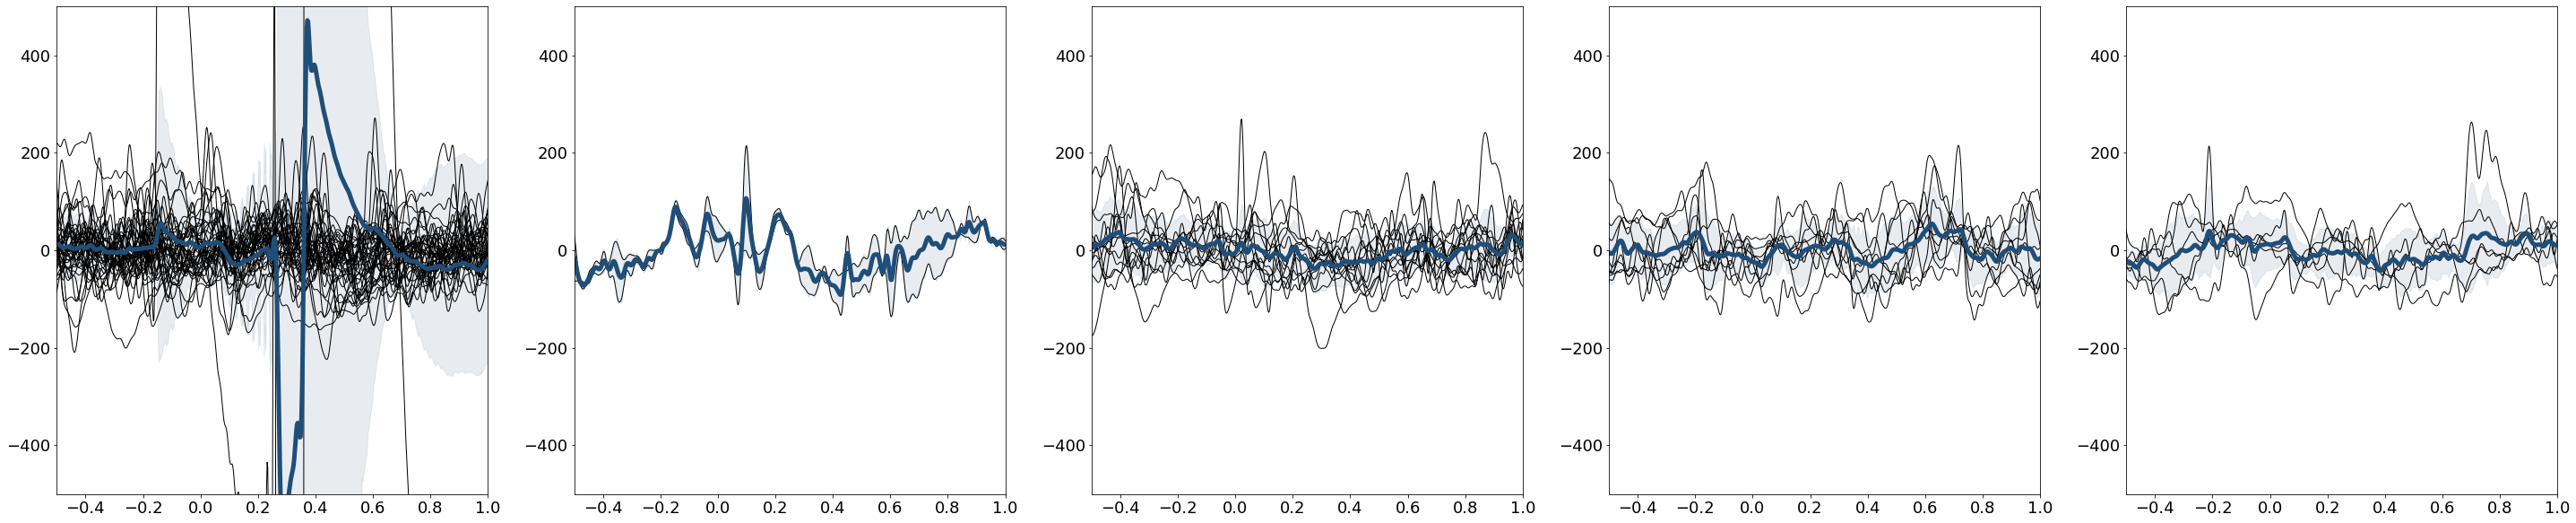

In [55]:
sc = 30
rc = 0

plot_mean_sleep(sc, rc,EEG_resp_CR, con_trial)

In [103]:
b = 37
stimlist_CR[(stimlist_CR.StimNum<4980)& (stimlist_CR.StimNum>4970)]

,StimNum,date,h,min,s,type,ChanP,ChanN,Num,Int_prob,Int_cond,IPI_ms,stim_block,noise,sleep,sz,condition
4971,4971,20220428,3,57,38,CR,23,24,137,3.0,0,0.0,36,0,0,0,0
4972,4972,20220428,3,57,42,CR,47,48,138,3.0,0,0.0,36,0,0,0,0
4973,4973,20220428,3,57,46,CR,4,5,139,3.0,0,0.0,36,0,0,0,0
4974,4974,20220428,3,57,52,CR,59,60,140,3.0,0,0.0,36,1,0,0,0
4975,4975,20220428,4,47,36,CR,3,4,0,3.0,0,0.0,37,0,2,0,0
4976,4976,20220428,4,47,40,CR,38,39,1,3.0,0,0.0,37,0,2,0,0
4977,4977,20220428,4,47,45,CR,8,9,2,3.0,0,0.0,37,0,2,0,0
4978,4978,20220428,4,47,49,CR,10,11,3,3.0,0,0.0,37,0,2,0,0
4979,4979,20220428,4,47,54,CR,22,23,4,3.0,0,0.0,37,0,2,0,0


In [124]:
con_trial.loc[(con_trial.Block>36), 'Num'] = con_trial.loc[(con_trial.Block>36), 'Num']+1

In [125]:
con_trial.loc[(con_trial.Chan==0)&(con_trial.Num>4970)&(con_trial.Num<4980)]

,Chan,Stim,LL,LL_peak,P2P,Sig_trial,Condition,Hour,Block,Sleep,Num,Num_block,Date,Sig_trial_LL,Sig_trial_P2P,d,Sig_block_surr,LL_mean,LL_mean_z
226782,0.0,20.0,1.526792,1.615390,109.471357,1.526792,0.0,3.0,36.0,0.0,4971.0,137.0,20220428.0,0.0,0.0,37.25,0.0,1.576698,1.739988
226783,0.0,42.0,1.256589,1.763766,109.531723,1.256589,0.0,3.0,36.0,0.0,4972.0,138.0,20220428.0,0.0,0.0,71.02,0.0,0.895119,-1.012485
226784,0.0,2.0,3.054746,3.662874,431.036922,3.054746,0.0,3.0,36.0,0.0,4973.0,139.0,20220428.0,1.0,1.0,7.00,1.0,3.893821,11.097396
233178,0.0,1.0,NaN,180.949113,22920.701815,NaN,0.0,4.0,37.0,2.0,4975.0,0.0,20220428.0,1.0,1.0,3.50,-1.0,-1.000000,-1.000000
233179,0.0,33.0,NaN,2.656568,143.504183,1.043877,0.0,4.0,37.0,2.0,4976.0,1.0,20220428.0,0.0,0.0,39.94,-1.0,-1.000000,-1.000000
233180,0.0,6.0,4.331514,4.930098,372.767897,4.331514,0.0,4.0,37.0,2.0,4977.0,2.0,20220428.0,1.0,0.0,21.00,1.0,3.259200,8.534560
233181,0.0,8.0,NaN,1.789725,111.583434,NaN,0.0,4.0,37.0,2.0,4978.0,3.0,20220428.0,0.0,0.0,28.00,-1.0,-1.000000,-1.000000
233182,0.0,19.0,1.513862,2.127369,228.262240,1.513862,0.0,4.0,37.0,2.0,4979.0,4.0,20220428.0,0.0,0.0,33.84,0.0,0.978088,-0.677427


In [123]:
stimlist_CR

,StimNum,date,h,min,s,type,ChanP,ChanN,Num,Int_prob,Int_cond,IPI_ms,stim_block,noise,sleep,sz,condition
0,0,20220426,16,53,42,CR,24,25,0,3.0,0,0.0,1,0,0,0,0
1,1,20220426,16,53,47,CR,47,48,1,3.0,0,0.0,1,0,0,0,0
2,2,20220426,16,53,51,CR,45,46,2,3.0,0,0.0,1,0,0,0,0
3,3,20220426,16,53,55,CR,50,51,3,3.0,0,0.0,1,0,0,0,0
4,4,20220426,16,54,0,CR,3,4,4,3.0,0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,5675,20220428,8,57,47,CR,9,10,136,3.0,0,0.0,41,0,0,0,0
5676,5676,20220428,8,57,52,CR,24,25,137,3.0,0,0.0,41,0,0,0,0
5677,5677,20220428,8,57,56,CR,53,54,138,3.0,0,0.0,41,0,0,0,0
5678,5678,20220428,8,58,1,CR,48,49,139,3.0,0,0.0,41,0,0,0,0


In [120]:
stimlist_CR = stimlist[(stimlist.type=='CR')]
stimlist_CR = stimlist_CR.reset_index(drop=True)

In [121]:
EEG_resp_CR = EEG_resp[:,stimlist_CR['StimNum'].values.astype('int'),:]

In [122]:
stimlist_CR.StimNum = np.arange(len(stimlist_CR))

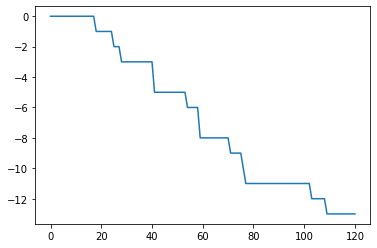

In [117]:
plt.plot((stimlist_CR.loc[(stimlist_CR.ChanP==24), 'StimNum'].values - con_trial.loc[(con_trial.Chan==0)&(con_trial.Stim==21), 'Num'].values))



In [118]:
stimlist_CR.loc[(stimlist_CR.ChanP==24), 'StimNum']

0          0
71        71
79        79
205      205
208      208
        ... 
5439    5439
5514    5514
5600    5600
5629    5629
5662    5662
Name: StimNum, Length: 121, dtype: int32

In [119]:
con_trial[(con_trial.Chan==0)&(con_trial.Stim==21)]

,Chan,Stim,LL,LL_peak,P2P,Sig_trial,Condition,Hour,Block,Sleep,Num,Num_block,Date,Sig_trial_LL,Sig_trial_P2P,d,Sig_block_surr,LL_mean,LL_mean_z
0,0.0,21.0,2.361117,3.513179,296.497964,2.361117,0.0,16.0,1.0,0.0,0.0,0.0,20220426.0,1.0,0.0,40.67,0.0,1.344885,0.803840
71,0.0,21.0,1.376848,1.612506,108.139386,1.376848,0.0,16.0,1.0,0.0,71.0,71.0,20220426.0,0.0,0.0,40.67,0.0,1.344885,0.803840
79,0.0,21.0,1.021118,1.398489,95.956962,1.021118,0.0,16.0,1.0,0.0,79.0,79.0,20220426.0,0.0,0.0,40.67,0.0,1.344885,0.803840
6690,0.0,21.0,0.954244,1.942436,174.487446,0.954244,0.0,17.0,2.0,0.0,205.0,64.0,20220426.0,0.0,0.0,40.67,0.0,1.149378,0.014309
6693,0.0,21.0,1.707677,2.102577,175.734811,1.707677,0.0,17.0,2.0,0.0,208.0,67.0,20220426.0,0.0,0.0,40.67,0.0,1.149378,0.014309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253064,0.0,21.0,2.000571,2.375066,228.242966,2.000571,0.0,7.0,40.0,0.0,5452.0,55.0,20220428.0,0.0,0.0,40.67,0.0,1.611776,1.881645
253139,0.0,21.0,1.097937,1.404343,171.794674,1.097937,0.0,7.0,40.0,0.0,5527.0,130.0,20220428.0,0.0,0.0,40.67,0.0,1.611776,1.881645
259710,0.0,21.0,0.880507,2.444361,244.309616,0.880507,0.0,8.0,41.0,0.0,5613.0,75.0,20220428.0,0.0,0.0,40.67,1.0,1.937743,3.198021
259739,0.0,21.0,3.106468,4.033339,467.396526,3.106468,0.0,8.0,41.0,0.0,5642.0,104.0,20220428.0,1.0,1.0,40.67,1.0,1.937743,3.198021


In [49]:
np.unique(con_trial.Num)

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 5.676e+03, 5.677e+03,
       5.678e+03])

In [152]:
lbls.Hemisphere.values+labels_all

array(['RAmy1', 'RAmy2', 'RAmy3', 'RAmy4', 'RAmy5', 'RWM6',
       'RCircIS_inf7', 'RCircIS_inf8', 'RCircIS_inf9', 'RSTS10', 'RSTS11',
       'RHIPP12', 'RHIPP13', 'RHIPP14', 'RHIPP15', 'ROTS_med16',
       'ROTS_med17', 'RWM18', 'RSTS19', 'RSTS20', 'RSTS21', 'RSTS22',
       'RENT23', 'RHIPP24', 'RHIPP25', 'RHIPP26', 'ROTS_med27', 'RWM28',
       'RSTS29', 'RSTS30', 'RSTS31', 'RSTS32', 'RSTS33', 'LAmy34',
       'LAmy35', 'LAmy36', 'LWM37', 'LWM38', 'LWM39', 'LSTS40', 'LSTS41',
       'LSTS42', 'LMTG43', 'LMTG44', 'LHIPP45', 'LHIPP46', 'LHIPP47',
       'LOTS_med48', 'LWM49', 'LSTS50', 'LSTS51', 'LSTS52', 'LSTS53',
       'LSTS54'], dtype=object)

In [150]:
lbls.Hemisphere.values

array(['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'L'], dtype=object)

In [236]:
long_dst_list = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.d<50)]

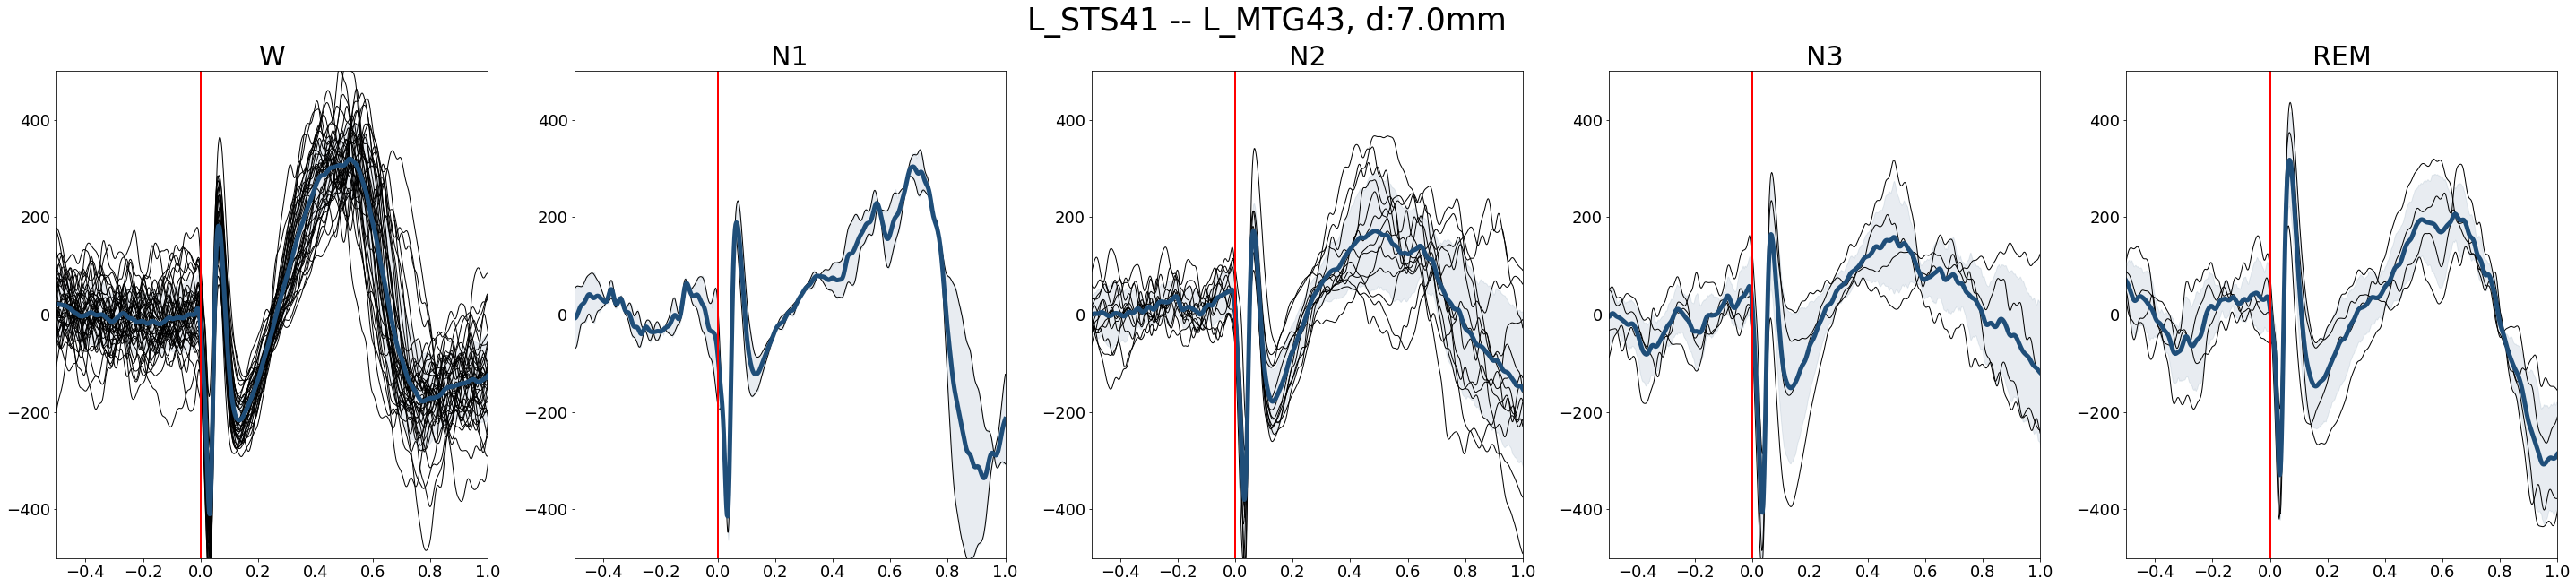

In [319]:
k = np.random.randint(0, len(long_dst_list))
sc = long_dst_list.Stim.values[k].astype('int')
rc = long_dst_list.Chan.values[k].astype('int')
plot_mean_sleep(sc, rc,EEG_resp_CR,  con_trial, lbls.Hemisphere.values+'_'+labels_all)

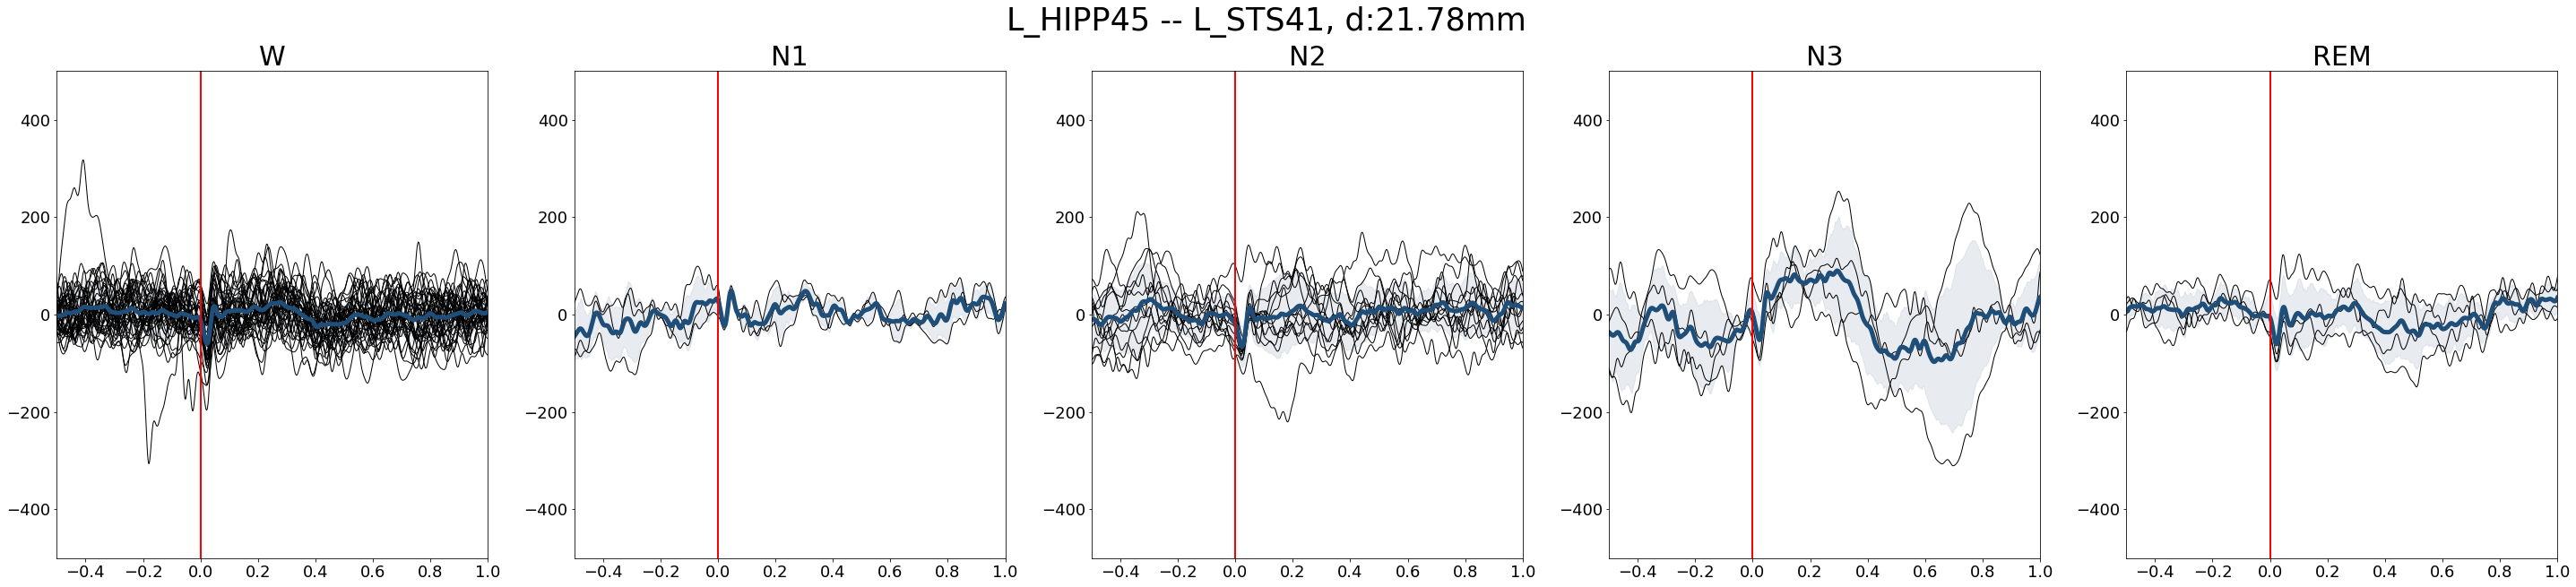

In [320]:
sc = 44
rc = 40
plot_mean_sleep(sc, rc,EEG_resp_CR,  con_trial, lbls.Hemisphere.values+'_'+labels_all)

In [128]:
sleep_labels = ['W', 'N1', 'N2', 'N3', 'REM']

In [154]:
def plot_mean_sleep(sc, rc,EEG_resp,  con_trial, labels_chan):
    data = con_trial[((con_trial.Hour >20)|(con_trial.Hour <9))&(con_trial.Stim ==sc) &(con_trial.Chan == rc) &(con_trial.LL >0) ]
    
    
    fig = plt.figure(figsize=(50,10))
    plt.suptitle(labels_chan[sc]+ ' -- '+labels_chan[rc]+', d:'+str(data.d.values[0])+'mm', fontsize=35)
    gs       = fig.add_gridspec(1,5)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for ss in range(5):
        # data
        data_ss = data[data.Sleep == ss]
        StimNum = data_ss.Num.values.astype('int')
        resp_mean = ff.lp_filter(np.mean(EEG_resp[rc, StimNum,:], 0),40,Fs)
        resp_std = np.std(EEG_resp[rc, StimNum,:], 0)
        # plot
        fig.add_subplot(gs[0, ss])
        plt.title(sleep_labels[ss], fontsize=30)
        for i in range(len(StimNum)):
            plt.plot(x_ax, ff.lp_filter(EEG_resp[rc, StimNum[i],:],40,Fs), c=[0,0,0], linewidth=1)
        plt.plot(x_ax, resp_mean, c=color_elab[0,:], linewidth=5)
    
        plt.fill_between(x_ax,resp_mean-resp_std,resp_mean+resp_std, color=color_elab[0,:], alpha = 0.1)
        #plt.xticks([])
        plt.tick_params(axis="y", labelsize=18)
        plt.tick_params(axis="x", labelsize=18)
        plt.axvline(0, linewidth=2, color=[1,0,0])
        plt.ylim([-500,500])
        plt.xlim([-0.5,1])
    
    


pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [5]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

In [6]:
labels_region_L = lbls.Hemisphere.values+'_'+labels_region

In [7]:
if os.path.isfile(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy') : 
    M_all = np.load(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy')
else:
    i =0
    for b in np.unique(con_trial.Block):
        summ = con_trial[(con_trial.LL>0)&(con_trial.Sig_block_surr ==1)&(con_trial.Block==b)]
        summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
        t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
        M = np.zeros((len(labels_all),len(labels_all)))
        for sc in np.unique(summ.Stim).astype('int'):
            chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
            LL =summ.loc[summ.Stim==sc, 'LL_peak'].values
            M[sc,chan] = LL
        M = np.nan_to_num(M)
        # BM plot
        labels_sel   = np.delete(labels_all, bad_all, 0)
        areas_sel    = np.delete(labels_region_L, bad_all, 0)
        M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

        # sort
        ind = np.argsort(areas_sel)
        areas_sel    = np.delete(labels_region, bad_all, 0)
        M_resp= M_resp[ind,:]
        M_resp = M_resp[:,ind]
        labels_sel = labels_sel[ind]
        areas_sel = areas_sel[ind]
        if i==0:
            M_all = M_resp
        elif i==1:
            M_all = np.stack([M_all, M_resp],0)
        else:
            M_all = np.concatenate([M_all,np.expand_dims(M_resp,0)],0)
        ll = 'BM'+str(int(b)).zfill(2)
        plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t)
        i = i+1
    np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy', M_all)

In [8]:
def plot_correleation_BM_hyp(M, binary=0):
    if binary:
        M[np.where(M>0)] = 1 
        M[np.where(M<=0)] = 0
        title = subj+'-- Correlation of connectivity (binary)'
        file = 'BM_corr_CR_binary'
    else:
        title = subj+'-- Correlation of connectivity (LL)'
        file = 'BM_corr_CR'
        
    df = pd.DataFrame(M.T)
    corrMatrix = df.corr().values

    fig = plt.figure(figsize=(25, 30))
    d_x = int(total_hour/5)
    gs       = fig.add_gridspec(2,1, height_ratios=[1,10])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ## hypnogram
    ax = fig.add_subplot(gs[0, 0])
    plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
    plt.axhspan(-1, 0.2, color=color_elab[0,:])
    plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
    #plt.ylabel('score', fontsize=25)
    plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'], fontsize=40)
    plt.ylim([-1,5])
    plt.gca().invert_yaxis()
    #plt.xticks(x_tick1,x_ax_h )
    plt.xticks([])
    plt.tick_params(axis="y", labelsize=18)
    
    ax = fig.add_subplot(gs[1, 0])
    plt.imshow(corrMatrix, cmap=plt.cm.jet, vmin=np.percentile(corrMatrix,20), vmax=np.percentile(corrMatrix,90))
    plt.ylabel('Block Number')
    plt.title(title)
    #plt.colorbar(extend='both')
    plt.xticks(x_block,x_hour , rotation=45)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'_hyp.svg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'_hyp.jpg')

    print(cond_folder +'/figures/BM_plot_trial_sig/'+file)
    plt.show()

In [9]:
stop

NameError: name 'stop' is not defined

In [ ]:
if cond_folder == 'CR':
    Mh    = np.copy(M_all)
    Mh[np.where(Mh==-1)] = np.nan
    Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #

    # delta = 0
    # Mh    = np.copy(BM_all)
    # Mh[np.where(Mh==-1)] = np.nan
    # 
    # Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #(70, 2916)
    # dist_flat  = distance.pdist(Mh_flat,'hamming') #(2415,)
    # M          = np.zeros((Mh.shape[0],Mh.shape[0]))
    # for i in range(Mh.shape[0]):
    #     for j in range(Mh.shape[0]):
    #         M[i,j] = dist_flat[int(Mh.shape[0] * i + j - ((i + 2) * (i + 1)) // 2)]
    x_block = np.unique(con_trial.Block)#[np.arange(0, len(Mh_flat),len(Mh_flat)/8).astype('int')]
    #np.arange(1, len(Mh_flat),4)
    x_hour =[]
    for b in x_block:
        x_raw = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
        x_hour.append(f"{x_raw:02}"+":00")

    plot_correleation_BM(Mh_flat, binary=0)
    #plot_correleation_BM_hyp(Mh_flat, binary=0)

In [ ]:
stimlist_hypno

## GRAPH

In [ ]:

# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nxviz
from nxviz.plots import CircosPlot, MatrixPlot, ArcPlot, BasePlot

In [ ]:
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region})
nodes   = nodes.drop(nodes[(nodes.Region == 'WM') | (nodes.Region == 'OUT') | (nodes.Region == 'Putamen')].index)
nodes  =nodes.reset_index(drop=True)

In [ ]:
def make_graph(nodes_df, edges_df):
    
    # make graph from nodes and edges
    g = nx.DiGraph()
    for i,row in nodes_df.iterrows():

        keys = row.index.tolist()

        values = row.values

        # The dict contains all attributes

        g.add_node(row['ID'], **dict(zip(keys,values)))


    for i,row in edges_df.iterrows():

        keys = row.index.tolist()

        values = row.values

        g.add_edge(row['source'], row['target'], weight=row['LL_peak'],**dict(zip(keys,values)))

    return g

In [ ]:
def get_graph(graph_dat, nodes, feature='LL_peak', labels_all=labels_all):
    #graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    graph_dat.insert(0, 'source',graph_dat.Stim )
    graph_dat.insert(0, 'target',graph_dat.Chan )
    for i in range(len(labels_all)):
        graph_dat.loc[graph_dat.Stim==i, 'source'] = labels_all[i]
        graph_dat.loc[graph_dat.Chan==i, 'target'] = labels_all[i]
    #G       = nx.from_pandas_edgelist(graph_dat, source="S", target="C",edge_attr="LL_peak")
    edges   = graph_dat.drop(columns=['Stim', 'Chan'])
    edges =edges.reset_index(drop=True)
    #print(edges.LL_peak.values[0])
    G       = make_graph(nodes, edges)
    #print(nx.info(G))
    return G

In [ ]:
deg_out = np.zeros((len(labels_all),len(np.unique(con_trial.Block))))
deg_in = np.zeros((len(labels_all),len(np.unique(con_trial.Block))))
den_arr = np.zeros((len(np.unique(con_trial.Block)),))
i = 0
for b in np.unique(con_trial.Block):
    data = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==b)]
    graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    G = get_graph(graph_dat, nodes)
    den_arr[i]= nx.density(G)
    for l in np.unique([graph_dat.target,graph_dat.source]):
        sc = np.where(labels_all==l)[0][0]
        deg_in[sc,i] = G.in_degree[l]
        deg_out[sc,i] = G.out_degree[l]
    i = i+1

In [ ]:
fig      =  plt.figure(figsize=(total_hour/4,8))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)


In [ ]:
ax = fig.add_subplot(gs[1, 0], sharex=ax)
plt.suptitle(subj+' -- Density of Connection Map across time', fontsize=18)
plt.scatter(time_overview.Hour_chron+0.5, time_overview.density)
plt.ylim([0.05, 0.2])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.svg')
plt.show()

In [ ]:
fig      =  plt.figure(figsize=(25,30))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,10])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'], fontsize=40)
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.pcolormesh(deg_out[:-1], cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_out,90))
plt.yticks(np.arange(len(labels_all)), labels_all, fontsize=20)
plt.xticks(np.linspace(0,deg_out[:-1].shape[1],d_x), time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45, fontsize=20)

plt.title('Degree out', fontsize=40)
plt.show()

In [ ]:
fig      =  plt.figure(figsize=(25,30))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,10])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'], fontsize=40)
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.pcolormesh(deg_in[:-1], cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_out,90))
plt.yticks(np.arange(len(labels_all)), labels_all, fontsize=20)
plt.xticks(np.linspace(0,deg_in[:-1].shape[1],d_x), time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45, fontsize=20)

plt.title('Degree in', fontsize=40)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.svg')
plt.show()

In [ ]:
plt.figure(figsize=(20, 18))
plt.imshow(deg_out, cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_in,90))
plt.xlabel('Block Number')
plt.yticks(np.arange(len(labels_all)), labels_all)
plt.title('Degree in')
plt.colorbar(extend='both')
# plt.xticks(x_block,x_hour , rotation=45)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_out.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_out.svg')
plt.show()

In [ ]:
plt.figure(figsize=(20, 18))
plt.imshow(deg_in, cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_in,90))
plt.xlabel('Block Number')
plt.yticks(np.arange(len(labels_all)), labels_all)
plt.title('Degree in')
plt.colorbar(extend='both')
# plt.xticks(x_block,x_hour , rotation=45)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.svg')
plt.show()

In [ ]:
den_arr = np.zeros((len(np.unique(con_trial.Block)),))
i = 0
for b in np.unique(con_trial.Block):
    data = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==b)] #&(con_trial.Sig_block>2)
    graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    G = get_graph(graph_dat, nodes)
    den_arr[i]= nx.density(G)
    i = i+1

In [131]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date==day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date==day[-1]), 'Hour']).astype('int')
total_hour = (len(day)-1)*24 -(t0-t1)+1

In [132]:
time_overview = np.zeros((total_hour,5))
b0 = np.min(con_trial.Block)
time_overview[:,:]=np.nan
time_overview[:,0] = np.arange(total_hour)
i = 0
h0 =  np.bincount(con_trial.loc[con_trial.Block==b0, 'Hour']).argmax()
for b in np.unique(con_trial.Block):
    date = np.bincount(con_trial.loc[con_trial.Block==b, 'Date']).argmax()
    d = np.where(day==date)[0]
    i = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax() +d*24-h0
    time_overview[i,1] = d
    time_overview[i,2] = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    time_overview[i,3] = b
    time_overview[i,4] = b
time_overview = pd.DataFrame(time_overview[:,:4], columns=['ix', 'Day', 'Hour', 'Block'])   
time_overview.insert(3,'Hour_label', 0)
for b in np.unique(time_overview.Block):
    if b>0:
        time_overview.loc[time_overview.Block==b, 'Hour_label'] = str(int(time_overview.loc[time_overview.Block==b, 'Hour'])).zfill(2)+':00'
    
time_overview.to_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

In [ ]:
time_overview = pd.read_csv(path_patient + '/Analysis/BrainMapping/CR/data/time_overview.csv')

In [ ]:
time_overview.insert(0, 'density', 0)
i =0
for b in np.unique(con_trial.Block):
    time_overview.loc[time_overview.Block==b, 'density'] = den_arr[i]
    i=i+1

In [133]:
# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
    


In [134]:
#add chornologic hours for plotting
#stimlist_hypno.insert(0, 'ix_chron', 0)
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_chron']= stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_h']+d*24
time_overview.insert(5, 'Hour_chron', time_overview.Hour+ time_overview.Day*24)  

In [150]:
d_x

8

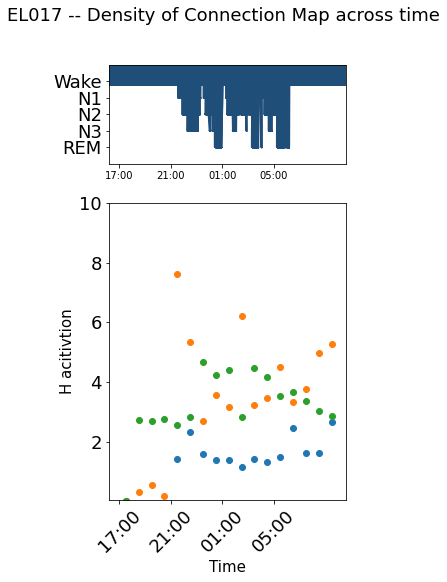

In [152]:
fig      =  plt.figure(figsize=(total_hour/4,8))

d_x = int(total_hour/4)
gs       = fig.add_gridspec(2,1, height_ratios=[1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0], sharex=ax)
plt.suptitle(subj+' -- Density of Connection Map across time', fontsize=18)
plt.scatter(time_overview_real.Hour_chron+0.5, H[0,:-1])
plt.scatter(time_overview_real.Hour_chron+0.5, H[1,:-1])
plt.scatter(time_overview_real.Hour_chron+0.5, H[2,:-1])
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-5,d_x).astype('int')].values, time_overview.Hour_label[np.linspace(0,total_hour-5,d_x).astype('int')].to_list(), rotation=45)
plt.ylim([0.05, 10])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('H acitivtion',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)


In [144]:
time_overview_real = time_overview[time_overview.Block>-1]
time_overview_real = time_overview_real.reset_index(drop=True)

In [145]:
time_overview_real

,ix,Day,Hour,Hour_label,Block,Hour_chron
0,0.0,0.0,17.0,17:00,1.0,17.0
1,1.0,0.0,18.0,18:00,2.0,18.0
2,2.0,0.0,19.0,19:00,3.0,19.0
3,3.0,0.0,20.0,20:00,4.0,20.0
4,4.0,0.0,21.0,21:00,5.0,21.0
5,5.0,0.0,22.0,22:00,6.0,22.0
6,6.0,0.0,23.0,23:00,7.0,23.0
7,7.0,1.0,0.0,00:00,8.0,24.0
8,8.0,1.0,1.0,01:00,9.0,25.0
9,9.0,1.0,2.0,02:00,10.0,26.0


In [56]:
time_overview_new = time_overview[time_overview.Block>20]

In [135]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_LL.npy'
M_Block = np.load(M_dir_path)

In [143]:
H.shape

(3, 18)

In [136]:
M_Block.shape

(18, 60, 60)

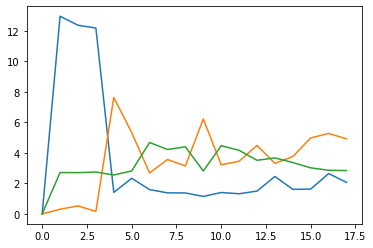

In [138]:
plt.plot(H[0])
plt.plot(H[1])
plt.plot(H[2])

In [137]:
M_Block_new = M_Block[0:,:,:]
M_B_nmf = M_Block_new.reshape(len(M_Block_new), -1)
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)] = 0
M_B_nmf[M_B_nmf < 0] = 0
# run NMF with rk = 3
rk = 3
W, W0, H = NMFf.get_nnmf_Epi(M_B_nmf, rk, it=2000)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [ ]:
fig      =  plt.figure(figsize=(total_hour/4,8))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0], sharex=ax)
plt.suptitle(subj+' -- Density of Connection Map across time', fontsize=18)
plt.scatter(time_overview.Hour_chron+0.5, time_overview.density)
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-1,d_x).astype('int')], time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45)
plt.ylim([0.05, 0.2])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.svg')
plt.show()

In [ ]:
plt.plot(time_overview.ix, time_overview.density)
plt.xticks(time_overview.ix, time_overview.Hour_label, rotation='vertical')
plt.ylim([0.1, 0.25])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('Density Value',  fontsize=15)

In [ ]:
data = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==8)] # &(con_trial.Sig_block>3)
graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
G = get_graph(graph_dat, nodes)

In [ ]:
label = 'BM'+str(int(b)).zfill(2)
c = CircosPlot(G, node_color='Region', group_label_position="middle", group_label_offset=12, node_grouping='Region', node_labels=True, node_label_layout='rotation', figsize=(8,8))

c.draw()
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/graph_'+label+'.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/graph_'+label+'.svg')

In [ ]:

data_test = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==8)] # &(con_trial.Sig_block>3)#LL_CCEP[(LL_CCEP.RespC==1)&(LL_CCEP.LL>1)&(LL_CCEP.d>50)]
data_test = data_test.drop(columns=['RespC', 'RespR', 'RespA','rLL', 'zLL', 'Day'])
data_test.insert(0,'Recs', 0)
data_test.insert(0,'Stims', 0)
for c in range(len(labels_all)):
    data_test.loc[(data_test.Stim ==c), "Region"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "RegionC"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "Recs"]   = labels_all[c]
    data_test.loc[(data_test.Stim ==c), "Stims"]  = labels_all[c]
data_test=data_test.drop(data_test[data_test.Region=='WM'].index)
data_test=data_test.drop(data_test[data_test.RegionC=='WM'].index)
data_test = data_test.drop(columns=['Region', 'RegionC'])
G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["LL", "d"])
edges   = nx.to_pandas_edgelist(G)
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes   = nodes.drop(nodes[nodes.Region=='WM'].index)
G       = make_graph(nodes, edges)

plt.figure(figsize=(15,15))
pos = nx.circular_layout(G) #nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos,edge_color='r', arrows=True)

plt.show()


## NMF

In [14]:
import NMF_funcs as NMFf

In [ ]:
con_trial

In [15]:
# add path
nmf_fig_path = path_patient_analysis + '/BrainMapping/' + cond_folder + '/NNMF/figures/'
nmf_path = path_patient_analysis + '/BrainMapping/' + cond_folder + '/NNMF/'
for path_find in [nmf_path, nmf_fig_path]:
    try:
        os.mkdir(path_find)
    except OSError:
        print(path_find + " -- already exists")

X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL020/BrainMapping/CR/NNMF/ -- already exists
X:\4 e-Lab\\EvM\Projects\EL_experiment\Analysis\Patients\EL020/BrainMapping/CR/NNMF/figures/ -- already exists


In [17]:
con_trial.insert(4,'LLs', np.nan)
con_trial.loc[(con_trial.Sig==1), 'LLs'] = con_trial.loc[(con_trial.Sig==1), 'LL']

In [ ]:
con_trial_nan = con_trial.copy(deep=True)

con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block', 'Sleep'])['LL_peak'].transform(
    lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block'])['LL_peak'].transform(
    lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Sleep'])['LL_peak'].transform(
    lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))

In [21]:
rk = 3

In [24]:
[W, H, H_sleep,W_pref_z] = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\NNMF\\nmf_rk' + str(
            rk) + '.npz')

In [27]:
H_sleep

'arr_2'

In [20]:
V_path = nmf_path + 'IO_LLpeak.npy'
title_LL = subj + ', Stim: all, LL as input'
if os.path.isfile(V_path):
    NMF_input = np.load(V_path)
else:
    con_trial_nan = con_trial.copy(deep=True)

    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block', 'Sleep'])['LL_peak'].transform(
        lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block'])['LL_peak'].transform(
        lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Sleep'])['LL_peak'].transform(
        lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))
    NMF_input = np.zeros((len(labels_all), len(np.unique(con_trial_nan.Num).astype('int'))))
    i = 0
    nums = con_trial_nan.Num.values
    nums, idx = np.unique(nums, return_index=True)

    for num in nums.astype('int'):
        # for num in nums[np.sort(idx)].astype('int'):
        dat = con_trial_nan[con_trial_nan.Num == num]
        chan = dat.Chan.values.astype('int')
        NMF_input[chan, i] = abs(dat.LL_peak.values)
        i = i + 1
    NMF_input = np.nan_to_num(NMF_input, nan=0)
    np.save(V_path, NMF_input)
    # todo: plot NMF input
    # W
    labels_clean = np.delete(labels_all, bad_region, 0)
    NMF_input_clean = np.delete(NMF_input, bad_region, 0)
    file = nmf_fig_path + 'NMF_input_IO_LLpeak'
    NMFf.plot_V(NMF_input_clean, subj + ' -- NMF input matrix: LL ', ylabels=labels_clean, file=file)

KeyError: 'Column not found: LL_peak'

In [ ]:
NMF_input = np.zeros((len(labels_all), len(np.unique(con_trial_nan.Num).astype('int'))))
i = 0
nums = con_trial_nan.Num.values
nums, idx = np.unique(nums, return_index=True)

for num in nums.astype('int'):
    # for num in nums[np.sort(idx)].astype('int'):
    dat = con_trial_nan[con_trial_nan.Num == num]
    chan = dat.Chan.values.astype('int')
    NMF_input[chan, i] = abs(dat.LL_peak.values)
    i = i + 1
NMF_input = np.nan_to_num(NMF_input, nan=0)
np.save(V_path, NMF_input)
# todo: plot NMF input
# W
labels_clean = np.delete(labels_all, bad_region, 0)
NMF_input_clean = np.delete(NMF_input, bad_region, 0)
file = nmf_fig_path + 'NMF_input_IO_LLpeak'
NMFf.plot_V(NMF_input_clean, subj + ' -- NMF input matrix: LL ', ylabels=labels_clean, file=file)

In [ ]:
NMFf.plot_V(NMF_input_clean, subj + ' -- NMF input matrix: LL ', ylabels=labels_clean)

In [ ]:
k0 = 3
k1 = 10
num_it = 25
ranks = np.arange(k0, k1 + 1)
stability, instability = NMFf.get_stability(NMF_input, num_it=num_it, k0=k0, k1=k1)
stab_sel = (stability / stability.max() - instability / instability.max())
ix0 = np.argmax(stab_sel)
print('Best Rank: '+ str(ranks[ix0]))

In [ ]:
rk = ranks[ix0]
[W, H] = NMFf.get_nnmf(NMF_input, rk, it=2000)

In [ ]:
con_trial

In [ ]:
col0 = ['Stim', 'Block', 'Hour', 'Date', 'Sleep', 'Num']  #  'Hour',
col = ['Stim', 'Block', 'Hour', 'Date', 'Sleep', 'Num']   #  'Hour',
W_col = []
H_col = []
for i in range(H.shape[0]):
    col.append('H' + str(i + 1))
    W_col.append('W' + str(i + 1))
    H_col.append('H' + str(i + 1))

con_nmf = np.zeros((H.shape[1], len(col0) + H.shape[0]))
con_nmf[:, len(col0):] = H.T
# add stim channel, Hour and Intensity
i = 0
for n in nums.astype('int'):
    for k in range(len(col0)):
        #np.bincount(con_trial.loc[con_trial.Num == n, col0[k]]).argmax()
        con_nmf[i, k] = con_trial.loc[con_trial.Num == n, col0[k]].values[0]
    i = i + 1

pd_con_nnmf = pd.DataFrame(con_nmf, columns=col)

In [ ]:
pd_con_nnmf

In [ ]:
for hl in H_col:
    thr = 1.2*np.median(pd_con_nnmf[hl])
    h_max = pd_con_nnmf.groupby(['Stim'])[hl].max().values
    h_min = pd_con_nnmf.groupby(['Stim'])[hl].min().values
    stim_sel = np.where(pd_con_nnmf.groupby(['Stim'])[hl].mean().values>thr)[0]
    pd_con_nnmf.insert(pd_con_nnmf.shape[1],'n'+hl , 0)
    for sc_clean in stim_sel.astype('int'):
        sc = Stims[sc_clean]
        pd_con_nnmf.loc[pd_con_nnmf.Stim==sc, 'n'+hl] = pd_con_nnmf.loc[pd_con_nnmf.Stim==sc, hl]/h_max[sc_clean]

In [ ]:
pd_con_nnmf= pd_con_nnmf.drop(columns=['nH3', 'nH2', 'nH1'])

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('normalized H fluctuation across time, all trials ')
gs    = fig.add_gridspec(len(H_col),1)
i =0
for hl in H_col:
    fig.add_subplot(gs[i,0])
    plt.title(hl, fontsize=15)
    data_plot = pd_con_nnmf[pd_con_nnmf['n'+hl]>0.1]
    plt.scatter(data_plot.Block,data_plot['n'+hl], alpha = 0.3)
    plt.plot(np.unique(data_plot.Block), data_plot.groupby(['Block'])['n'+hl].mean() , color=[0,0,0])
    #plt.xlim([0,3])
    plt.ylabel('normalized H by stim specific max')
    i = i+1
plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('normalized H fluctuation across time, all trials ')
gs    = fig.add_gridspec(len(H_col),1)
i =0
for hl in H_col:
    fig.add_subplot(gs[i,0])
    plt.title(hl, fontsize=15)
    data_plot = pd_con_nnmf[pd_con_nnmf['n'+hl]>0.1]
    plt.scatter(data_plot.Num,data_plot['n'+hl], alpha = 0.3)
    #plt.plot(np.unique(data_plot.Num), data_plot.groupby(['Num'])['n'+hl].mean() , color=[0,0,0])
    #plt.xlim([0,3])
    i = i+1
plt.xlabel('Trials')
#plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,17))
plt.suptitle('Finding stim channels associated to Activiation functions: H mean')
gs    = fig.add_gridspec(1,len(H_col))
i =0
for hl in H_col:
    fig.add_subplot(gs[0,i])
    plt.title(hl, fontsize=15)
    plt.errorbar( pd_con_nnmf.groupby(['Stim'])[hl].mean().values,np.unique(pd_con_nnmf.Stim), xerr=pd_con_nnmf.groupby(['Stim'])[hl].std().values, fmt='o')
    #plt.scatter( pd_con_nnmf[hl],pd_con_nnmf.Stim, alpha = 0.3)
    if i ==0:
        plt.yticks(np.arange(len(labels_all)), labels_all)
    else:
        plt.yticks([])
    plt.axvline(np.median(pd_con_nnmf[hl]), color=[0,0,0])
    #plt.axvline(np.median(pd_con_nnmf[hl])+np.std(pd_con_nnmf[hl]), color=[0,0,0])
    plt.xlim([0,4])
    i = i+1

plt.show()

fig = plt.figure(figsize=(20,2))
hl = 'H1'
dat_plot = pd_con_nnmf[(pd_con_nnmf.Stim==9)]
plt.scatter(dat_plot.Block,dat_plot[hl], alpha = 1)

plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('H fluctuation across time,all trials ')
gs    = fig.add_gridspec(len(H_col),1)
i =0
for hl in H_col:
    fig.add_subplot(gs[i,0])
    plt.title(hl, fontsize=15)
    plt.scatter(pd_con_nnmf.Block,pd_con_nnmf[hl], alpha = 0.3)
    #plt.xlim([0,3])
    i = i+1
plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(rk*2+2,17))
plt.suptitle('Finding stim channels associated to Activiation functions: H STD')
gs    = fig.add_gridspec(1,len(H_col))
i =0
for hl in H_col:
    fig.add_subplot(gs[0,i])
    plt.title(hl, fontsize=15)
    plt.scatter( pd_con_nnmf.groupby(['Stim'])[hl].std().values,np.unique(pd_con_nnmf.Stim))
    #plt.scatter( pd_con_nnmf[hl],pd_con_nnmf.Stim, alpha = 0.3)
    if i ==0:
        plt.yticks(np.arange(len(labels_all)), labels_all)
    else:
        plt.yticks([])
    plt.axvline(np.median(pd_con_nnmf.groupby(['Stim'])[hl].std().values), color=[0,0,0])
    #plt.xlim([0,3])
    i = i+1

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,17))
plt.suptitle('Finding stim channels associated to Activiation functions: H mean')
gs    = fig.add_gridspec(1,len(H_col))
i =0
for hl in H_col:
    fig.add_subplot(gs[0,i])
    plt.title(hl, fontsize=15)
    plt.errorbar( pd_con_nnmf.groupby(['Stim'])[hl].mean().values,np.unique(pd_con_nnmf.Stim), xerr=pd_con_nnmf.groupby(['Stim'])[hl].std().values, fmt='o')
    #plt.scatter( pd_con_nnmf[hl],pd_con_nnmf.Stim, alpha = 0.3)
    if i ==0:
        plt.yticks(np.arange(len(labels_all)), labels_all)
    else:
        plt.yticks([])
    plt.axvline(np.median(pd_con_nnmf[hl]), color=[0,0,0])
    #plt.axvline(np.median(pd_con_nnmf[hl])+np.std(pd_con_nnmf[hl]), color=[0,0,0])
    plt.xlim([0,4])
    i = i+1

plt.show()

In [ ]:
NMFf.plot_W(np.delete(W, bad_region, 0),  'Basic Function', ylabels = labels_clean, file=0)
NMFf.plot_H(H,  'Activation Function', file=0)

## BM connectivity plots on mean of LL trials

In [ ]:
def plot_BM_CR_trial(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=2, vmax= 15)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot_trial/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot_trial/GIF/BM_'+label+'.jpg')
    plt.close(fig)

In [ ]:
i =0
for b in np.unique(con_trial.Block):
    summ = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Sig_block==1)&(con_trial.Block==b)]
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    M = np.zeros((len(labels_all),len(labels_all)))
    for sc in np.unique(summ.Stim).astype('int'):
        chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
        LL =summ.loc[summ.Stim==sc, 'LL_peak'].values
        M[sc,chan] = LL
    M = np.nan_to_num(M)
    # BM plot
    labels_sel   = np.delete(labels_all, bad_region, 0)
    areas_sel    = np.delete(labels_region, bad_region, 0)
    M_resp       = np.delete(np.delete(M, bad_region, 0), bad_region, 1)

    # sort
    ind = np.argsort(areas_sel)
    M_resp= M_resp[ind,:]
    M_resp = M_resp[:,ind]
    labels_sel = labels_sel[ind]
    areas_sel = areas_sel[ind]
    if i==0:
        M_all = M_resp
    elif i==1:
        M_all = np.stack([M_all, M_resp],0)
    else:
        M_all = np.concatenate([M_all,np.expand_dims(M_resp,0)],0)
    ll = 'BM'+str(int(b)).zfill(2)
    plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t)
    i = i+1
np.save(path_patient + '/Analysis/BrainMapping/CR/data/BM_all_trial_sig.npy', M_all)

## Classic Brain Map

In [ ]:
con_trial

In [ ]:
con_trial.loc[np.isnan(con_trial.LL), 'LL_peak'] = np.nan

In [ ]:
#con_trial_block.insert(6, 'Prot', t)
block_l = files_list[l][-11:-4]
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_'+block_l+'.csv'
con_trial_block.to_csv(file, index=False, header=True)
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_mean_'+block_l+'.csv'
con_mean_cond.to_csv(file, index=False, header=True)
# todo: remobe WM, etc.
if l ==0:
    con_trial = con_trial_block
    BM_all = M_resp
elif l ==1:
    con_trial = pd.concat([con_trial, con_trial_block])
    BM_all = np.stack([BM_all,M_resp], 0)
else:
    con_trial = pd.concat([con_trial, con_trial_block])
    BM_all = np.concatenate([BM_all,np.expand_dims(M_resp,0)], 0)

In [ ]:
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/CR/data/BM_all.npy', BM_all)
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)

In [ ]:
int(1.5*Fs)

In [ ]:
def get_SigCon_BM_trial_block(LL_CCEP, EEG_resp, labels_all):
    # cond_sel: either Condition or Hour
    Fs = 500
    t_0 = 1
    M_resp = np.zeros((len(labels_all), len(labels_all), 3)) - 1
    # (LL_CCEP[cond_sel]==cond_val)
    resp_mean = np.zeros((1, 7))
    for rc in tqdm.tqdm(range(len(labels_all))):  # for each response channel
        for sc in range(len(labels_all)):  # for each stim channel
            lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]
            d = np.mean(
                LL_CCEP.loc[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc), 'd'])
            lists = lists[~np.isnan(lists.LL.values)]
            stimNum_all = lists.Num.values.astype('int')
            val = np.zeros((1, 7))
            val[0, 0:3] = [rc, sc, d]
            if len(stimNum_all) > 0:

                resp_z = bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs))
                mx = np.max(abs(resp_z[int(Fs):int(1.5*Fs)]))

                LL_CCEP.loc[
                        (LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = mx
            else:
                LL_CCEP.loc[(LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = -1


    return LL_CCEP

In [ ]:
file    = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_'+block_l+'.csv'
con_trial_block = pd.read_csv(file)

In [ ]:
def get_SigCon_BM_trial_block(LL_CCEP, EEG_resp, labels_all):
    # cond_sel: either Condition or Hour
    Fs = 500
    t_0 = 1
    M_resp = np.zeros((len(labels_all), len(labels_all), 3)) - 1
    # (LL_CCEP[cond_sel]==cond_val)
    resp_mean = np.zeros((1, 7))
    for rc in tqdm.tqdm(range(len(labels_all))):  # for each response channel
        for sc in range(len(labels_all)):  # for each stim channel
            lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]
            d = np.mean(
                LL_CCEP.loc[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc), 'd'])
            lists = lists[~np.isnan(lists.LL.values)]
            stimNum_all = lists.Num.values.astype('int')
            val = np.zeros((1, 7))
            val[0, 0:3] = [rc, sc, d]
            if len(stimNum_all) > 0:

                resp_z = bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs))
                mx = np.max(abs(resp_z[int(1.01*Fs):int(1.4*Fs)]))

                LL_CCEP.loc[
                        (LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = mx
            else:
                LL_CCEP.loc[(LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = -1


    return LL_CCEP

In [ ]:
for l in range(0,len(files_list)):
    print('loading '+files_list[l][-11:-4], end='\r')
    stimlist = pd.read_csv(files_list[l])
    EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')
    if EEG_resp.shape[1]!=len(stimlist):
        print('ERROR number of stimulations is not correct')
        break
    else:
        stimlist.StimNum = np.arange(len(stimlist))
        t = stimlist.type.values[0]
        #con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
        block_l = files_list[l][-11:-4]
        file    = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_'+block_l+'.csv'
        con_trial_block = pd.read_csv(file)
        con_trial_block = get_SigCon_BM_trial_block(con_trial_block, EEG_resp, labels_all)
        con_trial_block.to_csv(file, index=False, header=True)
        if l ==0:
            con_trial = con_trial_block
        else:
            con_trial = pd.concat([con_trial, con_trial_block])

con_trial.insert(9, 'Num_block', con_trial.Num)
mx = 0 
for b in np.unique(con_trial.Block):
    con_trial.loc[(con_trial.Block==b), 'Num'] = con_trial.loc[(con_trial.Block==b), 'Num_block']+mx
    mx = np.max(con_trial.loc[(con_trial.Block==b), 'Num'])   
#con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)
        

In [ ]:
con_trial.insert(9, 'Num_block', con_trial.Num)
mx = 0 
for b in np.unique(con_trial.Block):
    con_trial.loc[(con_trial.Block==b), 'Num'] = con_trial.loc[(con_trial.Block==b), 'Num_block']+mx
    mx = np.max(con_trial.loc[(con_trial.Block==b), 'Num'])   
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)

## Test differences

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))] #
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00")
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    mn = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    st  = np.std(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs),0)
    plt.plot(x_ax,mn, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    plt.fill_between(x_ax, mn-st, mn+st, color=color_elab[0], alpha= 0.3)
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.ylabel('[\u03BCV]', fontsize=18) #\u0394 delta
    plt.xlabel('time [s]', fontsize=18)
    plt.legend()
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/single_con/BM_'+str(b)+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/single_con/BM_'+str(b)+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.show()

In [ ]:
def plot_mean_zscore(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))] #&(~np.isnan(LL_CCEP.LL.values))
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00")
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        resp = ff.lp_filter(bf.zscore_CCEP(EEG_resp[rc,stimNum_all[i],:]),45,Fs)
        plt.plot(x_ax,resp, c=color_elab[0], linewidth=1, label='trial'+str(i+1))
    plt.plot(x_ax,ff.lp_filter(np.mean(bf.zscore_CCEP(EEG_resp[rc,stimNum_all,:]),0),45,Fs), c=[0,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)), c=[1,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))

    plt.xlim([-0.5,1])
    plt.ylim([-6,6])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    #plt.savefig()
    plt.show()

### BZD

In [ ]:
l =0
stimlist_BL= pd.read_csv(files_list[l])
EEG_resp_BL= np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:
l =1
stimlist_BZD= pd.read_csv(files_list[l])
EEG_resp_BZD= np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:
summ = con_trial[(con_trial.LL>0)&(con_trial.Sig_block_surr ==1)&(con_trial.Sig_block>5)]
summ = summ.groupby(['Stim', 'Chan', 'Block'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]

In [ ]:
con_trial

In [ ]:
con_trial[(con_trial.LL>0)&(con_trial.Stim ==sc)&(con_trial.Chan==rc)]

In [ ]:
plot_mean_zscore(sc, rc, con_trial[con_trial.Block==1], EEG_resp_BL, labels_all)
plot_mean_zscore(sc, rc, con_trial[con_trial.Block==3],EEG_resp_BZD, labels_all)

In [ ]:
sc = 78
rc = 67
plot_mean(sc, rc, con_trial[con_trial.Block==1], EEG_resp_BL, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==3],EEG_resp_BZD, labels_all)

In [ ]:
sc = 12
rc = 57
plot_mean(sc, rc, con_trial[con_trial.Block==1], EEG_resp_BL, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==3],EEG_resp_BZD, labels_all)

### CR

In [ ]:
l = 9
print('loading '+files_list[l][-11:-4], end='\r')
stimlist_9 = pd.read_csv(files_list[l])
EEG_resp_9 = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:
l = 22
print('loading '+files_list[l][-11:-4], end='\r')
stimlist_22 = pd.read_csv(files_list[l])
EEG_resp_22 = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:

plot_mean_zscore(sc, rc, con_trial[con_trial.Block==0], EEG_resp_9, labels_all)
plot_mean_zscore(sc, rc, con_trial[con_trial.Block==9],EEG_resp_22, labels_all)

In [ ]:
sc = 18
rc = 65
plot_mean(sc, rc, con_trial[con_trial.Block==9], EEG_resp_9, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==22],EEG_resp_22, labels_all)

In [ ]:
sc = 19
rc = 65
plot_mean(sc, rc, con_trial[con_trial.Block==9],EEG_resp_9, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==22],EEG_resp_22, labels_all)

In [ ]:
bf.zscore_CCEP

In [ ]:
'single_con'

In [ ]:
CR_labels = []
for i in range(24):
    CR_labels.append(f"{i:02}"+":00")

# Connectivvity correlation

## concat con_trial tables

In [ ]:
test = np.random.randint(0,50, (3,100))

In [ ]:
np.percentile(test, 99, 1).shape

In [ ]:
chan, trial = np.where(np.max(abs(EEG_resp[:, :, int(0.98 * Fs):int(1.02 * Fs)]), 2) > 2000)
for i in range(len(trial)):
    con_trial_block.loc[
        (con_trial_block.Chan == chan[i]) & (con_trial_block.Num == trial[i]), 'LL'] = np.nan

In [ ]:
for l in range(0,len(files_list)):
    print('loading '+files_list[l][-11:-4], end='\r')
    stimlist = pd.read_csv(files_list[l])
    EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')
    if EEG_resp.shape[1]!=len(stimlist):
        print('ERROR number of stimulations is not correct')
        break
    else:
        stimlist.StimNum = np.arange(len(stimlist))
        t = stimlist.type.values[0]
        con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
        
        # remove bad channels and stim channels (nan values)
        con_trial_block = con_trial_block[con_trial_block.LL>0]
        # con_trial_block = remove_art(EEG_resp, con_trial_block)
        # remove trials that have artefacts (high voltage values)
        chan, trial = np.where(np.max(abs(EEG_resp), 2) > 2000)
        for i in range(len(trial)):
            con_trial_block.loc[(con_trial_block.Chan == chan[i]) & (con_trial_block.Num == trial[i]), 'LL'] = np.nan
        con_trial_block = con_trial_block[~ np.isin(con_trial_block.Chan, bad_region)]
        #con_trial_block = con_trial_block[con_trial_block.d>7]
        #
        con_trial_block, con_mean_cond, M_resp = BMf.get_SigCon_BM_block(con_trial_block, EEG_resp, labels_all, chan_thr)
        # BM plot
        labels_sel   = np.delete(labels_all, bad_region, 0)
        areas_sel    = np.delete(labels_region, bad_region, 0)
        M_resp       = np.delete(np.delete(M_resp[:,:,2], bad_region, 0), bad_region, 1)
        
        # sort
        ind = np.argsort(areas_sel)
        M_resp= M_resp[ind,:]
        M_resp = M_resp[:,ind]
        labels_sel = labels_sel[ind]
        areas_sel = areas_sel[ind]

        t = np.bincount(stimlist.h).argmax()
        plot_BM_CR(M_resp, labels_sel, areas_sel, files_list[l][-8:-4], t)
        con_trial_block.insert(6, 'Prot', t)
        # todo: remobe WM, etc.
        if l ==0:
            con_trial = con_trial_block
            BM_all = M_resp
        elif l ==1:
            con_trial = pd.concat([con_trial, con_trial_block])
            BM_all = np.stack([BM_all,M_resp], 0)
        else:
            con_trial = pd.concat([con_trial, con_trial_block])
            BM_all = np.concatenate([BM_all,np.expand_dims(M_resp,0)], 0)
#con_trial = remove_art(EEG_resp, con_trial)
np.save(path_patient + '/Analysis/BrainMapping/CR/data/BM_all.npy', BM_all)
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_block.csv', index=False, header=True)
#np.save(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_block.npy', con_trial)
        

In [ ]:
con_trial

In [ ]:
stop

In [ ]:
df = pd.DataFrame(Mh_flat.T)
corr= df.corr().values

In [ ]:
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')


Mh    = np.copy(M_all)
Mh[np.where(Mh==-1)] = np.nan
Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #

delta = 0
Mh    = np.copy(BM_all)
Mh[np.where(Mh==-1)] = np.nan

Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #(70, 2916)
# dist_flat  = distance.pdist(Mh_flat,'hamming') #(2415,)
# M          = np.zeros((Mh.shape[0],Mh.shape[0]))
# for i in range(Mh.shape[0]):
#     for j in range(Mh.shape[0]):
#         M[i,j] = dist_flat[int(Mh.shape[0] * i + j - ((i + 2) * (i + 1)) // 2)]
x_block = np.unique(con_trial.Block)[np.arange(0, len(Mh_flat),len(Mh_flat)/5).astype('int')]
#np.arange(1, len(Mh_flat),4)
x_hour =[]
for b in x_block:
    x_raw = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    x_hour.append(f"{x_raw:02}"+":00")
    
plot_correleation_BM(Mh_flat, binary=0)

In [ ]:
plot_correleation_BM(Mh_flat, binary=1)

In [ ]:
stop

## LL and Significant responses 

exp         = 1
w           = 0.25
LL_CCEP     = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/CCEP_'+str(exp)+'_'+str(w)+'s.csv')

In [ ]:
chan_thr

In [ ]:
chan_thr    = pd.read_csv('T:\EL_experiment\Patients\EL009/Analysis/BrainMapping/LL/chan_sig_thr_BL.csv')


In [ ]:
w           = 0.25
LL_CCEP     = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/CCEP_'+str(w)+'s.csv')
chan_thr    = pd.read_csv('T:\EL_experiment\Patients\EL009/Analysis/BrainMapping/Ph/data/chan_sig_thr_BL.csv')


In [ ]:
w_r    = 0.1
w_LL   = 0.25
t_0    = 1 # time of stimulation in data
t_0s   = 0.5 # time of surr stim
t_Bl   = 0.5

## calcualte mean CCEp and then take LL 
data_CCEP                = np.zeros((1,10))
w                        = 0.25
stim_spec                = stimlist[(stimlist.IPI_ms ==0)]#&(stimlist.noise ==0) #&(stimlist.noise ==0
stimNum                  = stim_spec.StimNum.values#[:,0]
resps                    = ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs)
ChanP1                   = bf.SM2IX(stim_spec.ChanP.values,StimChanSM,np.array(StimChanIx))
LL_all       = LL_funcs.get_LL_both(data=resps, Fs=Fs, IPI=np.zeros((len(stimNum),1)), t_0=t_0, win=w_LL)
LL_r         = LL_funcs.get_LL_ratio(data=resps, Fs=Fs, IPI=np.zeros((len(stimNum),1)),t_bl=t_0-0.2, t_stim=t_0, win=w_r)
#LL_CCEP[sc, :, h, 0] = 
# remove Resp if rec channel was just stimulating before
#stim_spec0                = stimlist[(stimlist.StimNum.isin((stim_spec.StimNum.values-1)[1:]))]
#ChanP0                    = np.zeros((len(stimNum),))
#ChanP0[1:]                = bf.SM2IX(stim_spec0.ChanP.values,StimChanSM,np.array(StimChanIx))

for c in range(LL_all.shape[0]):
    val         = np.zeros((LL_all.shape[1], 10))
    val[:, 0]   = c                                         # response channel
    val[:, 1]   = bf.SM2IX(stim_spec.ChanP.values,StimChanSM,np.array(StimChanIx)) #stim Chan, in all labels
    val[:, 2]   = LL_all[c,:,1] ## LL absolute
    val[:, 3]   = stimNum
    val[:, 4]   = LL_r[c,:,1]
    val[:, 6]   = stim_spec.h.values
    #val[:, 7]   = stim_spec.condition.values
    val[:, 8]   = stim_spec.Int_prob.values
    val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic)==1),2] = np.nan
    val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic)==1),4] = np.nan

    # #ix         = np.where(np.max(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.01*Fs)]),1)>400)
    # pks         = np.max(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.5*Fs)]),1)
    # pks_loc     = np.argmax(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.5*Fs)]),1)+np.int64(0.95*Fs)
    # #ix         = np.where(np.max(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.01*Fs)]),1)>400)
    # ix          = np.where((pks>200)&(pks_loc>np.int64(0.955*Fs))&(pks_loc<np.int64(1.012*Fs)))
    # val[ix, 2] = np.nan
    # val[ix, 4] = np.nan
    # 
    # voltage_rec = np.percentile(abs(resps[c,:,0:np.int64(1*Fs)]),90,1)
    # ix          = np.where(voltage_rec>500)
    # val[ix, 2]  = np.nan
    # val[ix, 4]  = np.nan
    # #val[ix, 8] = np.nan
    # #val[ix, 9] = np.nan
    data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)

#LL_CCEP = pd.DataFrame(
#    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"d": data_CCEP[:, 5],"rLL": data_CCEP[:, 4],"zLL": data_CCEP[:, 4],"mx": data_CCEP[:, 8],"mx/std": data_CCEP[:, 9],"Day": data_CCEP[:, 7],"Hour": data_CCEP[:, 6],"Num": data_CCEP[:, 3]})
#
LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "Int": data_CCEP[:, 8], "LL": data_CCEP[:, 2],"d": data_CCEP[:, 5],"rLL": data_CCEP[:, 4],"zLL": data_CCEP[:, 4],"Condition": data_CCEP[:, 7],"Hour": data_CCEP[:, 6],"Num": data_CCEP[:, 3]})

LL_CCEP.loc[LL_CCEP['Chan'].isin(bad_chans), 'LL'] = np.nan
LL_CCEP.loc[LL_CCEP['Stim'].isin(bad_stims), 'LL'] = np.nan


##Z-score absolute
LL_BL_z   = np.zeros((len(labels_all),2))
LL_all_BL       = LL_funcs.get_LL_both(data=resps, Fs=Fs, IPI=np.zeros((len(stimNum),1)), t_0=t_Bl, win=w_LL)
LL_BL_z[:,0] = np.nanmean(LL_all_BL[:,:,1],1)
LL_BL_z[:,1] = np.nanstd(LL_all_BL[:,:,1],1)
for rc in range(len(labels_all)):
    LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'zLL'] = (LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL']- LL_BL_z[rc,0])/LL_BL_z[rc,1]

# distance
for i in range(len(StimChans)):
    ChanP = StimChanSM[i]
    s   = np.where(labels_all == StimChans[i])[0][0]#i#np.int(StimChanNums[i]) 
    s   = np.int64(s)
    for c in np.unique(LL_CCEP.Chan):
        c   = np.int64(c)
        LL_CCEP.loc[(LL_CCEP.Stim == s)&(LL_CCEP.Chan == c), 'd'] = math.sqrt(((coord_all[s,0]-coord_all[c,0])**2)+((coord_all[s,1]-coord_all[c,1])**2)+((coord_all[s,2]-coord_all[c,2])**2))

In [ ]:
CR_color = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24,3))
CR_color[6:18,:] =np.array([253, 184, 19 ])/255

In [ ]:
def plot_BM_CR(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[c], alpha = CR_color_a[c])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+label+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/GIF/BM_'+label+'.jpg')

In [ ]:
def get_LL_thr(EEG_resp, LL_all, labels_all, path_patient, n_trial=3):
    ## get threshoold value for each response channel (99th and 95h)
    chan_thr = np.zeros((len(labels_all), 4))
    for rc in range(len(labels_all)):
        chan_thr[rc,:] = get_sig_thr(rc, LL_all, EEG_resp, n_trial)
    data_A = pd.DataFrame(chan_thr, columns=['99', '95', 'std', 'mean'])
    data_A.to_csv(path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr_BL.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    print('Data stored')
    print(path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr_BL.csv')
    return chan_thr
def LL_mx(EEG_trial, Fs=500, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = ff.lp_filter(np.mean(EEG_trial,0),45,Fs)
    LL_resp        = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num, Fs=500,fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2,0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n              = 300 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)] # take BL when rc is not stimulating and not during noise
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice   = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.nanstd(LL_surr[:,0])
        thr[3] = np.nanmean(LL_surr[:,0]) 
        if fig_path != 'no':
            fig = plt.figure(figsize=(5,5))
            plt.title('surrogates - '+labels_all[rc])
            plt.hist(LL_surr[:,0])
            plt.axvline(thr[0], c= [1,0,0], label='99%')
            plt.axvline(thr[1], c= [1,0,0], label='90%')
            plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
            plt.xlabel('LL [250ms]')
            plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
            plt.legend()
            plt.savefig(fig_path)
            plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    #(LL_CCEP['Condition'].isin(cond))
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Int']==3)&(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                EEG_trial      = EEG_resp[rc,stimNum_all,:]
                mx,_,_         = LL_mx(EEG_trial)

                if  mx>chan_thr[rc, 0]:
                    M_resp[sc,rc,0] = mx
                    M_resp[sc,rc,1] = 1
                    M_resp[sc,rc,2] = (mx-chan_thr[rc,3])/chan_thr[rc, 2]
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
                else:
                    M_resp[sc,rc,:] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
            else:
                M_resp[sc,rc,:] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = -1

    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_all.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    return LL_CCEP, M_resp

def plot_BM(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()

In [ ]:
chan_thr  = get_LL_thr(EEG_resp, LL_CCEP, labels_all, path_patient)

In [ ]:
LL_CCEP, M_resp_BL = get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500)

In [ ]:
a = np.random.randint(0,10,(3,4))
a

In [ ]:
np.random.shuffle(a[:,1])
print(a)

In [ ]:
labels_sel   = np.delete(labels_clinic, bad_region, 0)
#labels_sel   = np.delete(labels_all, bad_region, 0)
areas_sel    = np.delete(labels_region, bad_region, 0)
M            = np.delete(np.delete(M_resp_BL[:,:,2], bad_region, 0), bad_region, 1)
# sort

plot_BM(M, labels_sel, areas_sel, 'BL_Clinic',0)

In [ ]:
areas_sel

In [ ]:
np.sort(areas_sel)

In [ ]:
## delete WM
# labels_sel   = np.delete(labels_clinic, bad_region, 0)
labels_sel   = np.delete(labels_all, bad_region, 0)
areas_sel    = np.delete(labels_region, bad_region, 0)
M            = np.delete(np.delete(M_resp_BL[:,:,2], bad_region, 0), bad_region, 1)

# sort
ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
#labels_sel   = labels_clinic
# sort

plot_BM(M, labels_sel, areas_sel, 'BL_Area', 1)

In [ ]:
def plot_BM(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()

In [ ]:
## delete WM
## sort
# ind = np.lexsort((areas_sel,labels_sel))
labels_sel   = np.delete(labels_all, bad_region, 0)

ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
# sort

plot_BM(M, labels_sel, areas_sel, 'BL_Area',1)

In [ ]:
np.array([ 7., 27., 55., 65.])

In [ ]:
rc = 0

In [ ]:
plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_all)

In [ ]:
rc = 0

In [ ]:
rc = rc+1
sc = 65

plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_clinic)


In [ ]:
dat      = LL_CCEP[(LL_CCEP['d']<10)&(LL_CCEP['RespC']==1)] #(LL_CCEP['d']<60)&
# 
k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])
plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_clinic)
plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_all)

In [ ]:
plot_mean(75, 28, LL_CCEP,EEG_resp, labels_all)

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.zLL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1, label='trial'+str(i+1))
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))
    
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
def get_LL_thr(EEG_resp, LL_all, labels_all, path_patient, n_trial=3):
    ## get threshoold value for each response channel (99th and 95h)
    chan_thr = np.zeros((len(labels_all), 4))
    for rc in range(len(labels_all)):
        chan_thr[rc,:] = get_sig_thr(rc, LL_all, EEG_resp, n_trial)
    data_A = pd.DataFrame(chan_thr, columns=['99', '95', 'std', 'mean'])
    data_A.to_csv(path_patient + '/Analysis/BrainMapping/data/chan_sig_thr_BL.csv', index=False,header=False)  # scat_plot = scat_plot.fillna(method='ffill')
    print('Data stored')
    print(path_patient + '/Analysis/BrainMapping/data/chan_sig_thr_BL.csv')
    return chan_thr
def LL_mx(EEG_trial, Fs=500, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = np.mean(EEG_trial,0)
    LL_resp        = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num, Fs=500,fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2,0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n              = 300 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)] # take BL when rc is not stimulating and not during noise
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice   = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.nanstd(LL_surr[:,0])
        thr[3] = np.nanmean(LL_surr[:,0]) 
        if fig_path != 'no':
            fig = plt.figure(figsize=(5,5))
            plt.title('surrogates - '+labels_all[rc])
            plt.hist(LL_surr[:,0])
            plt.axvline(thr[0], c= [1,0,0], label='99%')
            plt.axvline(thr[1], c= [1,0,0], label='90%')
            plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
            plt.xlabel('LL [250ms]')
            plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
            plt.legend()
            plt.savefig(fig_path)
            plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    #(LL_CCEP['Condition'].isin(cond))
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Int']==3)&(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                EEG_trial      = EEG_resp[rc,stimNum_all,:]
                mx,_,_         = LL_mx(EEG_trial)

                if  mx>chan_thr[rc, 0]:
                    M_resp[sc,rc,0] = mx
                    M_resp[sc,rc,1] = 1
                    M_resp[sc,rc,2] = (mx-chan_thr[rc,3])/chan_thr[rc, 2]
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
                else:
                    M_resp[sc,rc,:] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
            else:
                M_resp[sc,rc,:] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = -1

    return LL_CCEP, M_resp

def plot_BM(M, labels,areas, t='BL'):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    # for i in range(len(labels)):
    #     r = areas[i]
    #     axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    #     axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()